# Two-qubit States Reconstruction

In [2]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [3]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation

In [4]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [6]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [7]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [8]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [9]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [10]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [61]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity 

In [12]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [13]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [14]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

In [15]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [16]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [17]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [18]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [19]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [20]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [21]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [22]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [23]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [24]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 88ms/step - loss: 0.2090 - val_loss: 0.1980
Epoch 2/500
6/6 [==============================] - 0s 16ms/step - loss: 0.1926 - val_loss: 0.1855
Epoch 3/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1799 - val_loss: 0.1748
Epoch 4/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1685 - val_loss: 0.1649
Epoch 5/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1576 - val_loss: 0.1551
Epoch 6/500
6/6 [==============================] - 0s 17ms/step - loss: 0.1467 - val_loss: 0.1449
Epoch 7/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1353 - val_loss: 0.1345
Epoch 8/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1238 - val_loss: 0.1238
Epoch 9/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1121 - val_loss: 0.1129
Epoch 10/500
6/6 [==============================] - 0s 17ms/step - loss: 0.1005 - val_loss: 0.1022
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 85/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 86/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 87/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 88/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 89/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 90/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 91/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 92/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 93/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 94/5

6/6 [==============================] - 0s 17ms/step - loss: 5.3430e-04 - val_loss: 0.0015
Epoch 164/500
6/6 [==============================] - 0s 19ms/step - loss: 5.2323e-04 - val_loss: 0.0014
Epoch 165/500
6/6 [==============================] - 0s 16ms/step - loss: 5.0691e-04 - val_loss: 0.0014
Epoch 166/500
6/6 [==============================] - 0s 17ms/step - loss: 5.0867e-04 - val_loss: 0.0014
Epoch 167/500
6/6 [==============================] - 0s 20ms/step - loss: 5.0368e-04 - val_loss: 0.0014
Epoch 168/500
6/6 [==============================] - 0s 17ms/step - loss: 4.9230e-04 - val_loss: 0.0014
Epoch 169/500
6/6 [==============================] - 0s 21ms/step - loss: 4.9034e-04 - val_loss: 0.0014
Epoch 170/500
6/6 [==============================] - 0s 16ms/step - loss: 4.8437e-04 - val_loss: 0.0014
Epoch 171/500
6/6 [==============================] - 0s 16ms/step - loss: 4.8661e-04 - val_loss: 0.0014
Epoch 172/500
6/6 [==============================] - 0s 17ms/step - loss: 4.88

Epoch 242/500
6/6 [==============================] - 0s 17ms/step - loss: 3.1820e-04 - val_loss: 0.0011
Epoch 243/500
6/6 [==============================] - 0s 19ms/step - loss: 3.1640e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 17ms/step - loss: 3.2168e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 16ms/step - loss: 3.2289e-04 - val_loss: 0.0010
Epoch 246/500
6/6 [==============================] - 0s 16ms/step - loss: 3.1699e-04 - val_loss: 0.0010
Epoch 247/500
6/6 [==============================] - 0s 18ms/step - loss: 3.2016e-04 - val_loss: 0.0010
Epoch 248/500
6/6 [==============================] - 0s 17ms/step - loss: 3.2123e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 16ms/step - loss: 3.2412e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 17ms/step - loss: 3.2041e-04 - val_loss: 0.0010
Epoch 251/500
6/6 [==============================] - 0s 17ms/ste

6/6 [==============================] - 0s 17ms/step - loss: 2.2723e-04 - val_loss: 8.3593e-04
Epoch 319/500
6/6 [==============================] - 0s 17ms/step - loss: 2.2755e-04 - val_loss: 8.5157e-04
Epoch 320/500
6/6 [==============================] - 0s 16ms/step - loss: 2.2733e-04 - val_loss: 8.5024e-04
Epoch 321/500
6/6 [==============================] - 0s 17ms/step - loss: 2.2059e-04 - val_loss: 8.3887e-04
Epoch 322/500
6/6 [==============================] - 0s 16ms/step - loss: 2.2327e-04 - val_loss: 8.2370e-04
Epoch 323/500
6/6 [==============================] - 0s 16ms/step - loss: 2.2295e-04 - val_loss: 8.3454e-04
Epoch 324/500
6/6 [==============================] - 0s 17ms/step - loss: 2.2578e-04 - val_loss: 8.2416e-04
Epoch 325/500
6/6 [==============================] - 0s 17ms/step - loss: 2.2160e-04 - val_loss: 8.2470e-04
Epoch 326/500
6/6 [==============================] - 0s 16ms/step - loss: 2.1565e-04 - val_loss: 8.1599e-04
Epoch 327/500
6/6 [=======================

Epoch 394/500
6/6 [==============================] - 0s 21ms/step - loss: 1.6757e-04 - val_loss: 6.8865e-04
Epoch 395/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6495e-04 - val_loss: 6.7646e-04
Epoch 396/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6545e-04 - val_loss: 6.8129e-04
Epoch 397/500
6/6 [==============================] - 0s 18ms/step - loss: 1.6462e-04 - val_loss: 6.8965e-04
Epoch 398/500
6/6 [==============================] - 0s 18ms/step - loss: 1.6407e-04 - val_loss: 6.7326e-04
Epoch 399/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6194e-04 - val_loss: 6.7316e-04
Epoch 400/500
6/6 [==============================] - 0s 23ms/step - loss: 1.6159e-04 - val_loss: 6.7402e-04
Epoch 401/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6262e-04 - val_loss: 6.7928e-04
Epoch 402/500
6/6 [==============================] - 0s 23ms/step - loss: 1.6760e-04 - val_loss: 6.8397e-04
Epoch 403/500
6/6 [=========

Epoch 470/500
6/6 [==============================] - 0s 17ms/step - loss: 1.2887e-04 - val_loss: 5.7761e-04
Epoch 471/500
6/6 [==============================] - 0s 16ms/step - loss: 1.2939e-04 - val_loss: 5.7692e-04
Epoch 472/500
6/6 [==============================] - 0s 18ms/step - loss: 1.2984e-04 - val_loss: 5.7477e-04
Epoch 473/500
6/6 [==============================] - 0s 18ms/step - loss: 1.2982e-04 - val_loss: 5.7609e-04
Epoch 474/500
6/6 [==============================] - 0s 19ms/step - loss: 1.3606e-04 - val_loss: 5.7749e-04
Epoch 475/500
6/6 [==============================] - 0s 16ms/step - loss: 1.3359e-04 - val_loss: 5.8368e-04
Epoch 476/500
6/6 [==============================] - 0s 16ms/step - loss: 1.3845e-04 - val_loss: 5.7726e-04
Epoch 477/500
6/6 [==============================] - 0s 16ms/step - loss: 1.3524e-04 - val_loss: 5.6750e-04
Epoch 478/500
6/6 [==============================] - 0s 17ms/step - loss: 1.3085e-04 - val_loss: 5.7183e-04
Epoch 479/500
6/6 [=========

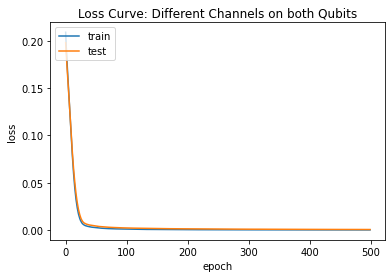

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.4060e-04 - 204ms/epoch - 29ms/step


In [27]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.9942133+1.5286838e-05j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [83]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [84]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [85]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [86]:
x_train_list = vectors_with_noise[:400]
y_train_list = vectors_noise_free[:400]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [87]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [88]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [89]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1500)

Epoch 1/1500
8/8 [==============================] - 2s 62ms/step - loss: 0.2111 - val_loss: 0.2096
Epoch 2/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.2059 - val_loss: 0.2048
Epoch 3/1500
8/8 [==============================] - 0s 20ms/step - loss: 0.2011 - val_loss: 0.2006
Epoch 4/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.1968 - val_loss: 0.1968
Epoch 5/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.1929 - val_loss: 0.1932
Epoch 6/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.1892 - val_loss: 0.1898
Epoch 7/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.1858 - val_loss: 0.1867
Epoch 8/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.1825 - val_loss: 0.1835
Epoch 9/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.1792 - val_loss: 0.1805
Epoch 10/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.1760 - val_loss: 0.1775
Epoch 11/

8/8 [==============================] - 0s 17ms/step - loss: 0.0133 - val_loss: 0.0163
Epoch 84/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0128 - val_loss: 0.0157
Epoch 85/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 86/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0117 - val_loss: 0.0145
Epoch 87/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0113 - val_loss: 0.0140
Epoch 88/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 0.0135
Epoch 89/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 90/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 91/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0096 - val_loss: 0.0121
Epoch 92/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0117
Epoch 93/1500


8/8 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 165/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 166/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 167/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 168/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 169/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 170/1500
8/8 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 171/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 172/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 173/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch

8/8 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 246/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 247/1500
8/8 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 248/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 249/1500
8/8 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 250/1500
8/8 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 251/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 252/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 253/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 254/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 9.7065e-04 - val_loss: 0.0017
Epoch 327/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.6710e-04 - val_loss: 0.0017
Epoch 328/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.6034e-04 - val_loss: 0.0017
Epoch 329/1500
8/8 [==============================] - 0s 18ms/step - loss: 9.5222e-04 - val_loss: 0.0017
Epoch 330/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.4644e-04 - val_loss: 0.0017
Epoch 331/1500
8/8 [==============================] - 0s 16ms/step - loss: 9.4255e-04 - val_loss: 0.0017
Epoch 332/1500
8/8 [==============================] - 0s 16ms/step - loss: 9.4046e-04 - val_loss: 0.0017
Epoch 333/1500
8/8 [==============================] - 0s 18ms/step - loss: 9.3083e-04 - val_loss: 0.0017
Epoch 334/1500
8/8 [==============================] - 0s 24ms/step - loss: 9.2715e-04 - val_loss: 0.0016
Epoch 335/1500
8/8 [==============================] - 0s 17ms/step - l

8/8 [==============================] - 0s 16ms/step - loss: 6.5441e-04 - val_loss: 0.0013
Epoch 405/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.5013e-04 - val_loss: 0.0013
Epoch 406/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.4773e-04 - val_loss: 0.0013
Epoch 407/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.4423e-04 - val_loss: 0.0013
Epoch 408/1500
8/8 [==============================] - 0s 15ms/step - loss: 6.4368e-04 - val_loss: 0.0013
Epoch 409/1500
8/8 [==============================] - 0s 15ms/step - loss: 6.3891e-04 - val_loss: 0.0013
Epoch 410/1500
8/8 [==============================] - 0s 13ms/step - loss: 6.3774e-04 - val_loss: 0.0013
Epoch 411/1500
8/8 [==============================] - 0s 20ms/step - loss: 6.3391e-04 - val_loss: 0.0012
Epoch 412/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.3093e-04 - val_loss: 0.0012
Epoch 413/1500
8/8 [==============================] - 0s 16ms/step - l

Epoch 482/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.6236e-04 - val_loss: 9.8163e-04
Epoch 483/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.5937e-04 - val_loss: 9.8274e-04
Epoch 484/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5762e-04 - val_loss: 9.7738e-04
Epoch 485/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.5630e-04 - val_loss: 9.7763e-04
Epoch 486/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.5354e-04 - val_loss: 9.7241e-04
Epoch 487/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.5215e-04 - val_loss: 9.6981e-04
Epoch 488/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5023e-04 - val_loss: 9.6550e-04
Epoch 489/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.4924e-04 - val_loss: 9.6344e-04
Epoch 490/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.4730e-04 - val_loss: 9.6461e-04
Epoch 491/1500
8/8 

8/8 [==============================] - 0s 17ms/step - loss: 3.4522e-04 - val_loss: 7.8117e-04
Epoch 558/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.4067e-04 - val_loss: 7.7660e-04
Epoch 559/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3949e-04 - val_loss: 7.7645e-04
Epoch 560/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3904e-04 - val_loss: 7.7540e-04
Epoch 561/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3807e-04 - val_loss: 7.7306e-04
Epoch 562/1500
8/8 [==============================] - 0s 16ms/step - loss: 3.3745e-04 - val_loss: 7.7133e-04
Epoch 563/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3561e-04 - val_loss: 7.6498e-04
Epoch 564/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3336e-04 - val_loss: 7.6608e-04
Epoch 565/1500
8/8 [==============================] - 0s 17ms/step - loss: 3.3246e-04 - val_loss: 7.6116e-04
Epoch 566/1500
8/8 [==============

8/8 [==============================] - 0s 17ms/step - loss: 2.5031e-04 - val_loss: 6.0954e-04
Epoch 633/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.4897e-04 - val_loss: 6.0244e-04
Epoch 634/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.4636e-04 - val_loss: 6.0430e-04
Epoch 635/1500
8/8 [==============================] - 0s 18ms/step - loss: 2.4718e-04 - val_loss: 6.0165e-04
Epoch 636/1500
8/8 [==============================] - 0s 18ms/step - loss: 2.5044e-04 - val_loss: 6.0537e-04
Epoch 637/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.4735e-04 - val_loss: 6.0168e-04
Epoch 638/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.4604e-04 - val_loss: 5.9351e-04
Epoch 639/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.4210e-04 - val_loss: 5.8973e-04
Epoch 640/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.4071e-04 - val_loss: 5.9103e-04
Epoch 641/1500
8/8 [==============

8/8 [==============================] - 0s 18ms/step - loss: 1.7944e-04 - val_loss: 4.6522e-04
Epoch 708/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.8147e-04 - val_loss: 4.6613e-04
Epoch 709/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.7833e-04 - val_loss: 4.6263e-04
Epoch 710/1500
8/8 [==============================] - 0s 20ms/step - loss: 1.7798e-04 - val_loss: 4.5986e-04
Epoch 711/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.7709e-04 - val_loss: 4.5678e-04
Epoch 712/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.7479e-04 - val_loss: 4.6420e-04
Epoch 713/1500
8/8 [==============================] - 0s 20ms/step - loss: 1.7635e-04 - val_loss: 4.5282e-04
Epoch 714/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.7337e-04 - val_loss: 4.5127e-04
Epoch 715/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.7089e-04 - val_loss: 4.5280e-04
Epoch 716/1500
8/8 [==============

8/8 [==============================] - 0s 18ms/step - loss: 1.2487e-04 - val_loss: 3.4864e-04
Epoch 783/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.2719e-04 - val_loss: 3.4002e-04
Epoch 784/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.2579e-04 - val_loss: 3.4039e-04
Epoch 785/1500
8/8 [==============================] - 0s 21ms/step - loss: 1.2430e-04 - val_loss: 3.3837e-04
Epoch 786/1500
8/8 [==============================] - 0s 20ms/step - loss: 1.2311e-04 - val_loss: 3.3920e-04
Epoch 787/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.2087e-04 - val_loss: 3.3306e-04
Epoch 788/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.2045e-04 - val_loss: 3.3451e-04
Epoch 789/1500
8/8 [==============================] - 0s 20ms/step - loss: 1.2061e-04 - val_loss: 3.2737e-04
Epoch 790/1500
8/8 [==============================] - 0s 20ms/step - loss: 1.2086e-04 - val_loss: 3.3246e-04
Epoch 791/1500
8/8 [==============

8/8 [==============================] - 0s 18ms/step - loss: 8.2972e-05 - val_loss: 2.4538e-04
Epoch 858/1500
8/8 [==============================] - 0s 18ms/step - loss: 8.0613e-05 - val_loss: 2.4210e-04
Epoch 859/1500
8/8 [==============================] - 0s 20ms/step - loss: 8.0753e-05 - val_loss: 2.4008e-04
Epoch 860/1500
8/8 [==============================] - 0s 18ms/step - loss: 7.9857e-05 - val_loss: 2.4068e-04
Epoch 861/1500
8/8 [==============================] - 0s 21ms/step - loss: 7.9472e-05 - val_loss: 2.3774e-04
Epoch 862/1500
8/8 [==============================] - 0s 18ms/step - loss: 7.9175e-05 - val_loss: 2.3858e-04
Epoch 863/1500
8/8 [==============================] - 0s 18ms/step - loss: 8.0633e-05 - val_loss: 2.3551e-04
Epoch 864/1500
8/8 [==============================] - 0s 18ms/step - loss: 7.9004e-05 - val_loss: 2.3454e-04
Epoch 865/1500
8/8 [==============================] - 0s 18ms/step - loss: 7.8371e-05 - val_loss: 2.3384e-04
Epoch 866/1500
8/8 [==============

8/8 [==============================] - 0s 19ms/step - loss: 4.9124e-05 - val_loss: 1.6801e-04
Epoch 933/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.8915e-05 - val_loss: 1.6813e-04
Epoch 934/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.7999e-05 - val_loss: 1.6789e-04
Epoch 935/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.8434e-05 - val_loss: 1.6443e-04
Epoch 936/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.7531e-05 - val_loss: 1.6199e-04
Epoch 937/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.7464e-05 - val_loss: 1.6029e-04
Epoch 938/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.6854e-05 - val_loss: 1.6038e-04
Epoch 939/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.6528e-05 - val_loss: 1.6223e-04
Epoch 940/1500
8/8 [==============================] - 0s 25ms/step - loss: 4.5848e-05 - val_loss: 1.6041e-04
Epoch 941/1500
8/8 [==============

8/8 [==============================] - 0s 18ms/step - loss: 2.6451e-05 - val_loss: 1.1176e-04
Epoch 1008/1500
8/8 [==============================] - 0s 28ms/step - loss: 2.6064e-05 - val_loss: 1.0984e-04
Epoch 1009/1500
8/8 [==============================] - 0s 25ms/step - loss: 2.5186e-05 - val_loss: 1.1012e-04
Epoch 1010/1500
8/8 [==============================] - 0s 18ms/step - loss: 2.4897e-05 - val_loss: 1.0976e-04
Epoch 1011/1500
8/8 [==============================] - 0s 18ms/step - loss: 2.4849e-05 - val_loss: 1.0900e-04
Epoch 1012/1500
8/8 [==============================] - 0s 19ms/step - loss: 2.5309e-05 - val_loss: 1.0768e-04
Epoch 1013/1500
8/8 [==============================] - 0s 20ms/step - loss: 2.4843e-05 - val_loss: 1.0780e-04
Epoch 1014/1500
8/8 [==============================] - 0s 19ms/step - loss: 2.4033e-05 - val_loss: 1.0691e-04
Epoch 1015/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.4443e-05 - val_loss: 1.0738e-04
Epoch 1016/1500
8/8 [=====

8/8 [==============================] - 0s 19ms/step - loss: 1.2190e-05 - val_loss: 7.6779e-05
Epoch 1082/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.2048e-05 - val_loss: 7.6130e-05
Epoch 1083/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.2174e-05 - val_loss: 7.6962e-05
Epoch 1084/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.2263e-05 - val_loss: 7.6964e-05
Epoch 1085/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.2018e-05 - val_loss: 7.6200e-05
Epoch 1086/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.1630e-05 - val_loss: 7.5165e-05
Epoch 1087/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.1874e-05 - val_loss: 7.4753e-05
Epoch 1088/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.1400e-05 - val_loss: 7.4243e-05
Epoch 1089/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.1434e-05 - val_loss: 7.3464e-05
Epoch 1090/1500
8/8 [=====

8/8 [==============================] - 0s 17ms/step - loss: 4.9565e-06 - val_loss: 5.4898e-05
Epoch 1156/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.8499e-06 - val_loss: 5.4291e-05
Epoch 1157/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.8001e-06 - val_loss: 5.4524e-05
Epoch 1158/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.7811e-06 - val_loss: 5.4338e-05
Epoch 1159/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.8962e-06 - val_loss: 5.3969e-05
Epoch 1160/1500
8/8 [==============================] - 0s 21ms/step - loss: 4.7145e-06 - val_loss: 5.3327e-05
Epoch 1161/1500
8/8 [==============================] - 0s 21ms/step - loss: 4.4037e-06 - val_loss: 5.3436e-05
Epoch 1162/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.3853e-06 - val_loss: 5.2838e-05
Epoch 1163/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.3140e-06 - val_loss: 5.2784e-05
Epoch 1164/1500
8/8 [=====

8/8 [==============================] - 0s 19ms/step - loss: 1.8449e-06 - val_loss: 4.3750e-05
Epoch 1230/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.7929e-06 - val_loss: 4.3820e-05
Epoch 1231/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.9727e-06 - val_loss: 4.3586e-05
Epoch 1232/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.9312e-06 - val_loss: 4.3450e-05
Epoch 1233/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.0524e-06 - val_loss: 4.4154e-05
Epoch 1234/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.9266e-06 - val_loss: 4.2991e-05
Epoch 1235/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.8504e-06 - val_loss: 4.3235e-05
Epoch 1236/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.7824e-06 - val_loss: 4.3507e-05
Epoch 1237/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.8292e-06 - val_loss: 4.3126e-05
Epoch 1238/1500
8/8 [=====

8/8 [==============================] - 0s 18ms/step - loss: 6.7055e-07 - val_loss: 3.8656e-05
Epoch 1304/1500
8/8 [==============================] - 0s 16ms/step - loss: 6.7504e-07 - val_loss: 3.8716e-05
Epoch 1305/1500
8/8 [==============================] - 0s 17ms/step - loss: 7.1807e-07 - val_loss: 3.8638e-05
Epoch 1306/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.2713e-07 - val_loss: 3.8526e-05
Epoch 1307/1500
8/8 [==============================] - 0s 17ms/step - loss: 5.8397e-07 - val_loss: 3.8621e-05
Epoch 1308/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.6306e-07 - val_loss: 3.8520e-05
Epoch 1309/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.8618e-07 - val_loss: 3.8428e-05
Epoch 1310/1500
8/8 [==============================] - 0s 18ms/step - loss: 6.3104e-07 - val_loss: 3.8396e-05
Epoch 1311/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.7532e-07 - val_loss: 3.8157e-05
Epoch 1312/1500
8/8 [=====

8/8 [==============================] - 0s 16ms/step - loss: 2.3829e-07 - val_loss: 3.5917e-05
Epoch 1378/1500
8/8 [==============================] - 0s 18ms/step - loss: 2.3137e-07 - val_loss: 3.5998e-05
Epoch 1379/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.2532e-07 - val_loss: 3.6088e-05
Epoch 1380/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.2314e-07 - val_loss: 3.6002e-05
Epoch 1381/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.2068e-07 - val_loss: 3.5953e-05
Epoch 1382/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.1832e-07 - val_loss: 3.5889e-05
Epoch 1383/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.3349e-07 - val_loss: 3.5901e-05
Epoch 1384/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.5565e-07 - val_loss: 3.5842e-05
Epoch 1385/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.6821e-07 - val_loss: 3.5834e-05
Epoch 1386/1500
8/8 [=====

8/8 [==============================] - 0s 16ms/step - loss: 1.1178e-07 - val_loss: 3.4943e-05
Epoch 1452/1500
8/8 [==============================] - 0s 18ms/step - loss: 1.1525e-07 - val_loss: 3.4911e-05
Epoch 1453/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.2560e-07 - val_loss: 3.4852e-05
Epoch 1454/1500
8/8 [==============================] - 0s 19ms/step - loss: 1.5203e-07 - val_loss: 3.4943e-05
Epoch 1455/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.2465e-07 - val_loss: 3.4897e-05
Epoch 1456/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.1105e-07 - val_loss: 3.4847e-05
Epoch 1457/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.2425e-07 - val_loss: 3.5030e-05
Epoch 1458/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.4096e-07 - val_loss: 3.4801e-05
Epoch 1459/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.2048e-07 - val_loss: 3.4854e-05
Epoch 1460/1500
8/8 [=====

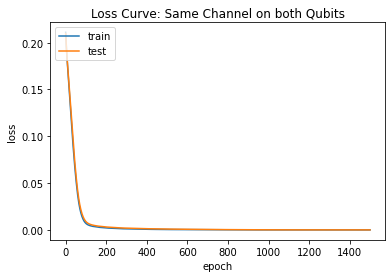

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 2.7044e-05 - 303ms/epoch - 43ms/step


In [92]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.99735415+4.1836757e-13j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [38]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [39]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [40]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [41]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [42]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [43]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [44]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 1s 53ms/step - loss: 0.2025 - val_loss: 0.1926
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1822 - val_loss: 0.1770
Epoch 3/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1656 - val_loss: 0.1630
Epoch 4/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1506 - val_loss: 0.1493
Epoch 5/500
6/6 [==============================] - 0s 17ms/step - loss: 0.1362 - val_loss: 0.1359
Epoch 6/500
6/6 [==============================] - 0s 17ms/step - loss: 0.1220 - val_loss: 0.1225
Epoch 7/500
6/6 [==============================] - 0s 25ms/step - loss: 0.1081 - val_loss: 0.1093
Epoch 8/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0947 - val_loss: 0.0968
Epoch 9/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0823 - val_loss: 0.0852
Epoch 10/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0709 - val_loss: 0.0744
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 85/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 86/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 87/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 88/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 89/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 90/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 91/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 92/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 93/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 94/5

6/6 [==============================] - 0s 16ms/step - loss: 7.5414e-04 - val_loss: 0.0022
Epoch 165/500
6/6 [==============================] - 0s 16ms/step - loss: 7.3870e-04 - val_loss: 0.0022
Epoch 166/500
6/6 [==============================] - 0s 16ms/step - loss: 7.3188e-04 - val_loss: 0.0022
Epoch 167/500
6/6 [==============================] - 0s 15ms/step - loss: 7.2819e-04 - val_loss: 0.0022
Epoch 168/500
6/6 [==============================] - 0s 16ms/step - loss: 7.2621e-04 - val_loss: 0.0022
Epoch 169/500
6/6 [==============================] - 0s 17ms/step - loss: 7.3231e-04 - val_loss: 0.0022
Epoch 170/500
6/6 [==============================] - 0s 17ms/step - loss: 7.2438e-04 - val_loss: 0.0022
Epoch 171/500
6/6 [==============================] - 0s 16ms/step - loss: 7.2013e-04 - val_loss: 0.0022
Epoch 172/500
6/6 [==============================] - 0s 16ms/step - loss: 7.1991e-04 - val_loss: 0.0021
Epoch 173/500
6/6 [==============================] - 0s 17ms/step - loss: 7.08

Epoch 243/500
6/6 [==============================] - 0s 16ms/step - loss: 5.0017e-04 - val_loss: 0.0019
Epoch 244/500
6/6 [==============================] - 0s 18ms/step - loss: 4.9769e-04 - val_loss: 0.0019
Epoch 245/500
6/6 [==============================] - 0s 17ms/step - loss: 4.9818e-04 - val_loss: 0.0019
Epoch 246/500
6/6 [==============================] - 0s 19ms/step - loss: 4.8540e-04 - val_loss: 0.0018
Epoch 247/500
6/6 [==============================] - 0s 19ms/step - loss: 4.8202e-04 - val_loss: 0.0019
Epoch 248/500
6/6 [==============================] - 0s 16ms/step - loss: 4.8191e-04 - val_loss: 0.0019
Epoch 249/500
6/6 [==============================] - 0s 16ms/step - loss: 4.8317e-04 - val_loss: 0.0018
Epoch 250/500
6/6 [==============================] - 0s 17ms/step - loss: 4.8045e-04 - val_loss: 0.0019
Epoch 251/500
6/6 [==============================] - 0s 18ms/step - loss: 4.7101e-04 - val_loss: 0.0018
Epoch 252/500
6/6 [==============================] - 0s 17ms/ste

Epoch 322/500
6/6 [==============================] - 0s 17ms/step - loss: 3.5386e-04 - val_loss: 0.0017
Epoch 323/500
6/6 [==============================] - 0s 15ms/step - loss: 3.5088e-04 - val_loss: 0.0017
Epoch 324/500
6/6 [==============================] - 0s 17ms/step - loss: 3.4990e-04 - val_loss: 0.0017
Epoch 325/500
6/6 [==============================] - 0s 17ms/step - loss: 3.5308e-04 - val_loss: 0.0017
Epoch 326/500
6/6 [==============================] - 0s 16ms/step - loss: 3.4966e-04 - val_loss: 0.0017
Epoch 327/500
6/6 [==============================] - 0s 17ms/step - loss: 3.5616e-04 - val_loss: 0.0017
Epoch 328/500
6/6 [==============================] - 0s 16ms/step - loss: 3.5374e-04 - val_loss: 0.0017
Epoch 329/500
6/6 [==============================] - 0s 16ms/step - loss: 3.5512e-04 - val_loss: 0.0017
Epoch 330/500
6/6 [==============================] - 0s 16ms/step - loss: 3.5193e-04 - val_loss: 0.0017
Epoch 331/500
6/6 [==============================] - 0s 17ms/ste

Epoch 401/500
6/6 [==============================] - 0s 21ms/step - loss: 2.8239e-04 - val_loss: 0.0016
Epoch 402/500
6/6 [==============================] - 0s 19ms/step - loss: 2.8530e-04 - val_loss: 0.0016
Epoch 403/500
6/6 [==============================] - 0s 21ms/step - loss: 2.7722e-04 - val_loss: 0.0016
Epoch 404/500
6/6 [==============================] - 0s 20ms/step - loss: 2.6955e-04 - val_loss: 0.0016
Epoch 405/500
6/6 [==============================] - 0s 20ms/step - loss: 2.7730e-04 - val_loss: 0.0016
Epoch 406/500
6/6 [==============================] - 0s 20ms/step - loss: 2.6792e-04 - val_loss: 0.0016
Epoch 407/500
6/6 [==============================] - 0s 21ms/step - loss: 2.6752e-04 - val_loss: 0.0016
Epoch 408/500
6/6 [==============================] - 0s 21ms/step - loss: 2.6858e-04 - val_loss: 0.0016
Epoch 409/500
6/6 [==============================] - 0s 20ms/step - loss: 2.7033e-04 - val_loss: 0.0016
Epoch 410/500
6/6 [==============================] - 0s 21ms/ste

Epoch 480/500
6/6 [==============================] - 0s 16ms/step - loss: 2.2851e-04 - val_loss: 0.0016
Epoch 481/500
6/6 [==============================] - 0s 17ms/step - loss: 2.3116e-04 - val_loss: 0.0016
Epoch 482/500
6/6 [==============================] - 0s 17ms/step - loss: 2.2747e-04 - val_loss: 0.0016
Epoch 483/500
6/6 [==============================] - 0s 15ms/step - loss: 2.3052e-04 - val_loss: 0.0016
Epoch 484/500
6/6 [==============================] - 0s 16ms/step - loss: 2.3790e-04 - val_loss: 0.0015
Epoch 485/500
6/6 [==============================] - 0s 16ms/step - loss: 2.3143e-04 - val_loss: 0.0015
Epoch 486/500
6/6 [==============================] - 0s 18ms/step - loss: 2.3235e-04 - val_loss: 0.0015
Epoch 487/500
6/6 [==============================] - 0s 21ms/step - loss: 2.2600e-04 - val_loss: 0.0015
Epoch 488/500
6/6 [==============================] - 0s 19ms/step - loss: 2.2545e-04 - val_loss: 0.0015
Epoch 489/500
6/6 [==============================] - 0s 16ms/ste

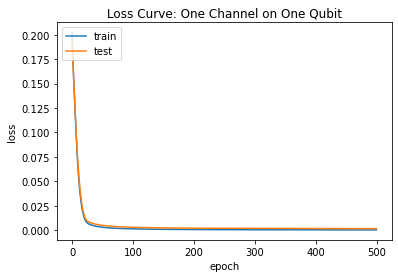

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0014 - 203ms/epoch - 29ms/step


In [47]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.99235076+1.9622298e-06j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [48]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [49]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [50]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [51]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[800:900]
y_val_list = vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[900:]
y_test_list = vectors_noise_free[900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [55]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),    
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [56]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [57]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=2000)

Epoch 1/2000
8/8 [==============================] - 2s 55ms/step - loss: 0.7486 - val_loss: 0.7133
Epoch 2/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.7177 - val_loss: 0.6854
Epoch 3/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.6869 - val_loss: 0.6561
Epoch 4/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.6551 - val_loss: 0.6251
Epoch 5/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.6208 - val_loss: 0.5920
Epoch 6/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.5849 - val_loss: 0.5566
Epoch 7/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.5474 - val_loss: 0.5195
Epoch 8/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.5096 - val_loss: 0.4824
Epoch 9/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.4723 - val_loss: 0.4468
Epoch 10/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.4366 - val_loss: 0.4134
Epoch 11/

8/8 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0303
Epoch 84/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0247 - val_loss: 0.0298
Epoch 85/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0294
Epoch 86/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0238 - val_loss: 0.0290
Epoch 87/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0235 - val_loss: 0.0286
Epoch 88/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0231 - val_loss: 0.0282
Epoch 89/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0227 - val_loss: 0.0278
Epoch 90/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0224 - val_loss: 0.0274
Epoch 91/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0270
Epoch 92/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0217 - val_loss: 0.0266
Epoch 93/2000


8/8 [==============================] - 0s 14ms/step - loss: 0.0097 - val_loss: 0.0129
Epoch 165/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0096 - val_loss: 0.0128
Epoch 166/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0127
Epoch 167/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 168/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0125
Epoch 169/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0093 - val_loss: 0.0124
Epoch 170/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0092 - val_loss: 0.0122
Epoch 171/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0122
Epoch 172/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0121
Epoch 173/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0120
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 246/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 247/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0075
Epoch 248/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 249/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 250/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 251/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0074
Epoch 252/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 253/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 254/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0073
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 327/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 328/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 329/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 330/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 331/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 332/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 333/2000
8/8 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 334/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 335/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 408/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 409/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 410/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 411/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 412/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 413/2000
8/8 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 414/2000
8/8 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 415/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 416/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 489/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 490/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 491/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 492/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 493/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 494/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 495/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 496/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 497/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 570/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 571/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 572/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 573/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 574/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 575/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 576/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 577/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 578/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 651/2000
8/8 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 652/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 653/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 654/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 655/2000
8/8 [==============================] - 0s 13ms/step - loss: 9.9709e-04 - val_loss: 0.0019
Epoch 656/2000
8/8 [==============================] - 0s 14ms/step - loss: 9.9356e-04 - val_loss: 0.0019
Epoch 657/2000
8/8 [==============================] - 0s 13ms/step - loss: 9.8729e-04 - val_loss: 0.0019
Epoch 658/2000
8/8 [==============================] - 0s 15ms/step - loss: 9.8563e-04 - val_loss: 0.0019
Epoch 659/2000
8/8 [==============================] - 0s 16ms/step - loss: 9.8795e-04 - va

8/8 [==============================] - 0s 14ms/step - loss: 7.8412e-04 - val_loss: 0.0015
Epoch 729/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.8305e-04 - val_loss: 0.0015
Epoch 730/2000
8/8 [==============================] - 0s 21ms/step - loss: 7.7883e-04 - val_loss: 0.0015
Epoch 731/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.7955e-04 - val_loss: 0.0015
Epoch 732/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.7590e-04 - val_loss: 0.0015
Epoch 733/2000
8/8 [==============================] - 0s 14ms/step - loss: 7.7561e-04 - val_loss: 0.0015
Epoch 734/2000
8/8 [==============================] - 0s 14ms/step - loss: 7.7112e-04 - val_loss: 0.0015
Epoch 735/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.6813e-04 - val_loss: 0.0015
Epoch 736/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.6309e-04 - val_loss: 0.0015
Epoch 737/2000
8/8 [==============================] - 0s 13ms/step - l

8/8 [==============================] - 0s 15ms/step - loss: 6.1898e-04 - val_loss: 0.0012
Epoch 807/2000
8/8 [==============================] - 0s 15ms/step - loss: 6.1924e-04 - val_loss: 0.0012
Epoch 808/2000
8/8 [==============================] - 0s 15ms/step - loss: 6.1662e-04 - val_loss: 0.0012
Epoch 809/2000
8/8 [==============================] - 0s 15ms/step - loss: 6.1474e-04 - val_loss: 0.0012
Epoch 810/2000
8/8 [==============================] - 0s 16ms/step - loss: 6.1341e-04 - val_loss: 0.0012
Epoch 811/2000
8/8 [==============================] - 0s 14ms/step - loss: 6.0769e-04 - val_loss: 0.0012
Epoch 812/2000
8/8 [==============================] - 0s 14ms/step - loss: 6.0466e-04 - val_loss: 0.0012
Epoch 813/2000
8/8 [==============================] - 0s 14ms/step - loss: 6.0683e-04 - val_loss: 0.0012
Epoch 814/2000
8/8 [==============================] - 0s 14ms/step - loss: 6.0216e-04 - val_loss: 0.0012
Epoch 815/2000
8/8 [==============================] - 0s 14ms/step - l

8/8 [==============================] - 0s 14ms/step - loss: 4.7820e-04 - val_loss: 9.9577e-04
Epoch 885/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7945e-04 - val_loss: 9.8743e-04
Epoch 886/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7943e-04 - val_loss: 9.7676e-04
Epoch 887/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7783e-04 - val_loss: 9.7821e-04
Epoch 888/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7660e-04 - val_loss: 9.7238e-04
Epoch 889/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7444e-04 - val_loss: 9.7532e-04
Epoch 890/2000
8/8 [==============================] - 0s 13ms/step - loss: 4.7032e-04 - val_loss: 9.7839e-04
Epoch 891/2000
8/8 [==============================] - 0s 15ms/step - loss: 4.6972e-04 - val_loss: 9.6431e-04
Epoch 892/2000
8/8 [==============================] - 0s 13ms/step - loss: 4.6726e-04 - val_loss: 9.5863e-04
Epoch 893/2000
8/8 [==============

8/8 [==============================] - 0s 13ms/step - loss: 3.7690e-04 - val_loss: 7.7817e-04
Epoch 960/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.7240e-04 - val_loss: 7.6991e-04
Epoch 961/2000
8/8 [==============================] - 0s 13ms/step - loss: 3.6994e-04 - val_loss: 7.6558e-04
Epoch 962/2000
8/8 [==============================] - 0s 13ms/step - loss: 3.6807e-04 - val_loss: 7.6500e-04
Epoch 963/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6555e-04 - val_loss: 7.6735e-04
Epoch 964/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6620e-04 - val_loss: 7.6434e-04
Epoch 965/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6848e-04 - val_loss: 7.6278e-04
Epoch 966/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6540e-04 - val_loss: 7.5308e-04
Epoch 967/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6471e-04 - val_loss: 7.5122e-04
Epoch 968/2000
8/8 [==============

Epoch 1034/2000
8/8 [==============================] - 0s 16ms/step - loss: 2.8027e-04 - val_loss: 6.0476e-04
Epoch 1035/2000
8/8 [==============================] - 0s 16ms/step - loss: 2.7924e-04 - val_loss: 6.0597e-04
Epoch 1036/2000
8/8 [==============================] - 0s 16ms/step - loss: 2.7628e-04 - val_loss: 6.0082e-04
Epoch 1037/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.7493e-04 - val_loss: 5.9923e-04
Epoch 1038/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.7261e-04 - val_loss: 5.9284e-04
Epoch 1039/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.7164e-04 - val_loss: 5.9570e-04
Epoch 1040/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.7114e-04 - val_loss: 5.9225e-04
Epoch 1041/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.7061e-04 - val_loss: 5.9065e-04
Epoch 1042/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.6748e-04 - val_loss: 5.8894e-04
Epoch 1043

8/8 [==============================] - 0s 13ms/step - loss: 1.9915e-04 - val_loss: 4.5810e-04
Epoch 1109/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.0016e-04 - val_loss: 4.5700e-04
Epoch 1110/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.9720e-04 - val_loss: 4.4513e-04
Epoch 1111/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.9601e-04 - val_loss: 4.4511e-04
Epoch 1112/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.9598e-04 - val_loss: 4.4108e-04
Epoch 1113/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.9294e-04 - val_loss: 4.3771e-04
Epoch 1114/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.9024e-04 - val_loss: 4.3651e-04
Epoch 1115/2000
8/8 [==============================] - 0s 18ms/step - loss: 1.8922e-04 - val_loss: 4.4248e-04
Epoch 1116/2000
8/8 [==============================] - 0s 18ms/step - loss: 1.9095e-04 - val_loss: 4.3864e-04
Epoch 1117/2000
8/8 [=====

8/8 [==============================] - 0s 17ms/step - loss: 1.2896e-04 - val_loss: 3.1580e-04
Epoch 1183/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.2746e-04 - val_loss: 3.1456e-04
Epoch 1184/2000
8/8 [==============================] - 0s 19ms/step - loss: 1.2703e-04 - val_loss: 3.1579e-04
Epoch 1185/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.2567e-04 - val_loss: 3.1119e-04
Epoch 1186/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.2588e-04 - val_loss: 3.1061e-04
Epoch 1187/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.2267e-04 - val_loss: 3.0708e-04
Epoch 1188/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.2188e-04 - val_loss: 3.0347e-04
Epoch 1189/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.2278e-04 - val_loss: 3.0458e-04
Epoch 1190/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.2090e-04 - val_loss: 3.0414e-04
Epoch 1191/2000
8/8 [=====

8/8 [==============================] - 0s 17ms/step - loss: 7.6136e-05 - val_loss: 2.0183e-04
Epoch 1257/2000
8/8 [==============================] - 0s 17ms/step - loss: 7.5628e-05 - val_loss: 2.0297e-04
Epoch 1258/2000
8/8 [==============================] - 0s 19ms/step - loss: 7.5629e-05 - val_loss: 2.0199e-04
Epoch 1259/2000
8/8 [==============================] - 0s 17ms/step - loss: 7.3876e-05 - val_loss: 1.9763e-04
Epoch 1260/2000
8/8 [==============================] - 0s 15ms/step - loss: 7.3001e-05 - val_loss: 1.9977e-04
Epoch 1261/2000
8/8 [==============================] - 0s 16ms/step - loss: 7.2447e-05 - val_loss: 1.9764e-04
Epoch 1262/2000
8/8 [==============================] - 0s 18ms/step - loss: 7.2329e-05 - val_loss: 1.9543e-04
Epoch 1263/2000
8/8 [==============================] - 0s 17ms/step - loss: 7.1207e-05 - val_loss: 1.9046e-04
Epoch 1264/2000
8/8 [==============================] - 0s 16ms/step - loss: 6.9907e-05 - val_loss: 1.9201e-04
Epoch 1265/2000
8/8 [=====

8/8 [==============================] - 0s 13ms/step - loss: 3.9117e-05 - val_loss: 1.2220e-04
Epoch 1331/2000
8/8 [==============================] - 0s 15ms/step - loss: 3.8186e-05 - val_loss: 1.2479e-04
Epoch 1332/2000
8/8 [==============================] - 0s 13ms/step - loss: 3.8555e-05 - val_loss: 1.2256e-04
Epoch 1333/2000
8/8 [==============================] - 0s 13ms/step - loss: 3.8282e-05 - val_loss: 1.2112e-04
Epoch 1334/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.8440e-05 - val_loss: 1.2399e-04
Epoch 1335/2000
8/8 [==============================] - 0s 16ms/step - loss: 3.7432e-05 - val_loss: 1.2007e-04
Epoch 1336/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6139e-05 - val_loss: 1.1888e-04
Epoch 1337/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.6187e-05 - val_loss: 1.1817e-04
Epoch 1338/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.5537e-05 - val_loss: 1.1741e-04
Epoch 1339/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 1.8286e-05 - val_loss: 7.9476e-05
Epoch 1405/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.8484e-05 - val_loss: 7.9226e-05
Epoch 1406/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.7802e-05 - val_loss: 7.7507e-05
Epoch 1407/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.7530e-05 - val_loss: 7.7179e-05
Epoch 1408/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.7202e-05 - val_loss: 7.7603e-05
Epoch 1409/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.6975e-05 - val_loss: 7.6824e-05
Epoch 1410/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.6721e-05 - val_loss: 7.5781e-05
Epoch 1411/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.6430e-05 - val_loss: 7.6012e-05
Epoch 1412/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.6297e-05 - val_loss: 7.4966e-05
Epoch 1413/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 9.0870e-06 - val_loss: 5.5953e-05
Epoch 1479/2000
8/8 [==============================] - 0s 16ms/step - loss: 8.9999e-06 - val_loss: 5.6276e-05
Epoch 1480/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.8178e-06 - val_loss: 5.4910e-05
Epoch 1481/2000
8/8 [==============================] - 0s 16ms/step - loss: 8.5514e-06 - val_loss: 5.6395e-05
Epoch 1482/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.3511e-06 - val_loss: 5.5285e-05
Epoch 1483/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.3797e-06 - val_loss: 5.5277e-05
Epoch 1484/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.6199e-06 - val_loss: 5.4797e-05
Epoch 1485/2000
8/8 [==============================] - 0s 15ms/step - loss: 8.3285e-06 - val_loss: 5.4907e-05
Epoch 1486/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.1692e-06 - val_loss: 5.4178e-05
Epoch 1487/2000
8/8 [=====

8/8 [==============================] - 0s 17ms/step - loss: 5.1760e-06 - val_loss: 4.6304e-05
Epoch 1553/2000
8/8 [==============================] - 0s 16ms/step - loss: 4.9756e-06 - val_loss: 4.6247e-05
Epoch 1554/2000
8/8 [==============================] - 0s 14ms/step - loss: 5.0583e-06 - val_loss: 4.6517e-05
Epoch 1555/2000
8/8 [==============================] - 0s 14ms/step - loss: 5.1234e-06 - val_loss: 4.5832e-05
Epoch 1556/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.7380e-06 - val_loss: 4.5476e-05
Epoch 1557/2000
8/8 [==============================] - 0s 15ms/step - loss: 4.6689e-06 - val_loss: 4.4931e-05
Epoch 1558/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.5890e-06 - val_loss: 4.5384e-05
Epoch 1559/2000
8/8 [==============================] - 0s 14ms/step - loss: 4.6815e-06 - val_loss: 4.5734e-05
Epoch 1560/2000
8/8 [==============================] - 0s 15ms/step - loss: 4.7432e-06 - val_loss: 4.6384e-05
Epoch 1561/2000
8/8 [=====

8/8 [==============================] - 0s 16ms/step - loss: 2.9568e-06 - val_loss: 3.9106e-05
Epoch 1627/2000
8/8 [==============================] - 0s 13ms/step - loss: 2.8782e-06 - val_loss: 3.9360e-05
Epoch 1628/2000
8/8 [==============================] - 0s 21ms/step - loss: 2.7660e-06 - val_loss: 3.8875e-05
Epoch 1629/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.9398e-06 - val_loss: 3.9352e-05
Epoch 1630/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.9254e-06 - val_loss: 3.9571e-05
Epoch 1631/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.2402e-06 - val_loss: 3.8478e-05
Epoch 1632/2000
8/8 [==============================] - 0s 14ms/step - loss: 3.2596e-06 - val_loss: 3.9057e-05
Epoch 1633/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.8978e-06 - val_loss: 3.8444e-05
Epoch 1634/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.9371e-06 - val_loss: 3.8671e-05
Epoch 1635/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 2.3481e-06 - val_loss: 3.4758e-05
Epoch 1701/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.2962e-06 - val_loss: 3.4707e-05
Epoch 1702/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.1571e-06 - val_loss: 3.3967e-05
Epoch 1703/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.9344e-06 - val_loss: 3.4122e-05
Epoch 1704/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.9472e-06 - val_loss: 3.4127e-05
Epoch 1705/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.1426e-06 - val_loss: 3.4950e-05
Epoch 1706/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.1043e-06 - val_loss: 3.4885e-05
Epoch 1707/2000
8/8 [==============================] - 0s 15ms/step - loss: 2.1137e-06 - val_loss: 3.4402e-05
Epoch 1708/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.0460e-06 - val_loss: 3.4714e-05
Epoch 1709/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 1.6952e-06 - val_loss: 3.2111e-05
Epoch 1775/2000
8/8 [==============================] - 0s 18ms/step - loss: 1.5442e-06 - val_loss: 3.2749e-05
Epoch 1776/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.4662e-06 - val_loss: 3.2120e-05
Epoch 1777/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.5366e-06 - val_loss: 3.2225e-05
Epoch 1778/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.6250e-06 - val_loss: 3.2386e-05
Epoch 1779/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.5301e-06 - val_loss: 3.2322e-05
Epoch 1780/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.5622e-06 - val_loss: 3.2637e-05
Epoch 1781/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.9845e-06 - val_loss: 3.2362e-05
Epoch 1782/2000
8/8 [==============================] - 0s 18ms/step - loss: 1.4900e-06 - val_loss: 3.1755e-05
Epoch 1783/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 1.1520e-06 - val_loss: 3.0407e-05
Epoch 1849/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.1861e-06 - val_loss: 3.0808e-05
Epoch 1850/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.2613e-06 - val_loss: 3.1132e-05
Epoch 1851/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.1221e-06 - val_loss: 3.0622e-05
Epoch 1852/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.2320e-06 - val_loss: 3.1664e-05
Epoch 1853/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.3490e-06 - val_loss: 3.0684e-05
Epoch 1854/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.3171e-06 - val_loss: 3.1321e-05
Epoch 1855/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.3521e-06 - val_loss: 3.0761e-05
Epoch 1856/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.5288e-06 - val_loss: 3.2014e-05
Epoch 1857/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 9.5010e-07 - val_loss: 2.9724e-05
Epoch 1923/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.0727e-06 - val_loss: 2.9550e-05
Epoch 1924/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.1738e-06 - val_loss: 3.0243e-05
Epoch 1925/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.0120e-06 - val_loss: 3.0238e-05
Epoch 1926/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.1580e-06 - val_loss: 2.9483e-05
Epoch 1927/2000
8/8 [==============================] - 0s 14ms/step - loss: 9.6552e-07 - val_loss: 2.9833e-05
Epoch 1928/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.2117e-06 - val_loss: 2.9808e-05
Epoch 1929/2000
8/8 [==============================] - 0s 15ms/step - loss: 1.2836e-06 - val_loss: 2.9743e-05
Epoch 1930/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.1129e-06 - val_loss: 2.9957e-05
Epoch 1931/2000
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 9.7334e-07 - val_loss: 2.8507e-05
Epoch 1997/2000
8/8 [==============================] - 0s 14ms/step - loss: 8.6993e-07 - val_loss: 2.8879e-05
Epoch 1998/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.0999e-06 - val_loss: 3.0234e-05
Epoch 1999/2000
8/8 [==============================] - 0s 14ms/step - loss: 2.0278e-06 - val_loss: 3.1189e-05
Epoch 2000/2000
8/8 [==============================] - 0s 13ms/step - loss: 2.0752e-06 - val_loss: 3.1723e-05


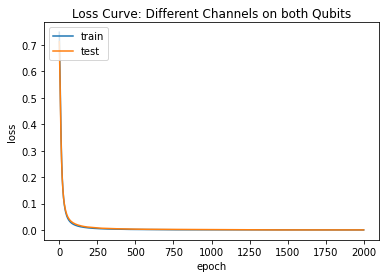

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
score = model.evaluate(x_test,  y_test, verbose=2)

35/35 - 0s - loss: 2.4944e-05 - 487ms/epoch - 14ms/step


In [62]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((0.99997556-6.457412e-13j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [63]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [64]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [65]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [66]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[900:1200]
y_val_list = vectors_noise_free[900:1200]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1200:]
y_test_list = vectors_noise_free[1200:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [67]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [68]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [69]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1500)

Epoch 1/1500
8/8 [==============================] - 2s 62ms/step - loss: 0.7127 - val_loss: 0.6973
Epoch 2/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.6814 - val_loss: 0.6677
Epoch 3/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.6504 - val_loss: 0.6371
Epoch 4/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.6185 - val_loss: 0.6050
Epoch 5/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.5850 - val_loss: 0.5708
Epoch 6/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.5499 - val_loss: 0.5341
Epoch 7/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.5124 - val_loss: 0.4960
Epoch 8/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.4743 - val_loss: 0.4567
Epoch 9/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.4351 - val_loss: 0.4182
Epoch 10/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.3980 - val_loss: 0.3818
Epoch 11/

8/8 [==============================] - 0s 14ms/step - loss: 0.0245 - val_loss: 0.0284
Epoch 84/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0241 - val_loss: 0.0279
Epoch 85/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0237 - val_loss: 0.0275
Epoch 86/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0233 - val_loss: 0.0271
Epoch 87/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0229 - val_loss: 0.0267
Epoch 88/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0225 - val_loss: 0.0263
Epoch 89/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0222 - val_loss: 0.0259
Epoch 90/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 91/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0252
Epoch 92/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0211 - val_loss: 0.0248
Epoch 93/1500


8/8 [==============================] - 0s 16ms/step - loss: 0.0089 - val_loss: 0.0116
Epoch 165/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 166/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0087 - val_loss: 0.0114
Epoch 167/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0087 - val_loss: 0.0113
Epoch 168/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 169/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 170/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0110
Epoch 171/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 172/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0109
Epoch 173/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0108
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 246/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 247/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 248/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 249/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 250/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0065
Epoch 251/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0065
Epoch 252/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 253/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 254/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 327/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 328/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 329/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 330/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 331/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 332/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 333/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 334/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 335/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 408/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 409/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 410/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 411/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 412/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 413/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 414/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 415/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 416/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 489/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 490/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 491/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 492/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 493/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 494/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 495/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 496/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 497/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 570/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 571/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 572/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 573/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 574/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 575/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 576/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 577/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 578/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch

Epoch 650/1500
8/8 [==============================] - 0s 14ms/step - loss: 9.7611e-04 - val_loss: 0.0017
Epoch 651/1500
8/8 [==============================] - 0s 16ms/step - loss: 9.7263e-04 - val_loss: 0.0017
Epoch 652/1500
8/8 [==============================] - 0s 14ms/step - loss: 9.7159e-04 - val_loss: 0.0017
Epoch 653/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.6340e-04 - val_loss: 0.0016
Epoch 654/1500
8/8 [==============================] - 0s 14ms/step - loss: 9.5889e-04 - val_loss: 0.0017
Epoch 655/1500
8/8 [==============================] - 0s 16ms/step - loss: 9.6084e-04 - val_loss: 0.0016
Epoch 656/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.5543e-04 - val_loss: 0.0016
Epoch 657/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.5341e-04 - val_loss: 0.0016
Epoch 658/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.4935e-04 - val_loss: 0.0016
Epoch 659/1500
8/8 [==============================] - 0

8/8 [==============================] - 0s 14ms/step - loss: 7.6851e-04 - val_loss: 0.0013
Epoch 729/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.6294e-04 - val_loss: 0.0013
Epoch 730/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.6021e-04 - val_loss: 0.0013
Epoch 731/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.5508e-04 - val_loss: 0.0013
Epoch 732/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.5995e-04 - val_loss: 0.0013
Epoch 733/1500
8/8 [==============================] - 0s 17ms/step - loss: 7.5555e-04 - val_loss: 0.0013
Epoch 734/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.5194e-04 - val_loss: 0.0013
Epoch 735/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.4572e-04 - val_loss: 0.0013
Epoch 736/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.3942e-04 - val_loss: 0.0013
Epoch 737/1500
8/8 [==============================] - 0s 14ms/step - l

8/8 [==============================] - 0s 15ms/step - loss: 6.0324e-04 - val_loss: 0.0011
Epoch 807/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.0764e-04 - val_loss: 0.0011
Epoch 808/1500
8/8 [==============================] - 0s 15ms/step - loss: 6.0462e-04 - val_loss: 0.0010
Epoch 809/1500
8/8 [==============================] - 0s 15ms/step - loss: 6.0012e-04 - val_loss: 0.0011
Epoch 810/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.9481e-04 - val_loss: 0.0010
Epoch 811/1500
8/8 [==============================] - 0s 15ms/step - loss: 5.9011e-04 - val_loss: 0.0010
Epoch 812/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.8696e-04 - val_loss: 0.0010
Epoch 813/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.9172e-04 - val_loss: 0.0010
Epoch 814/1500
8/8 [==============================] - 0s 15ms/step - loss: 5.8749e-04 - val_loss: 0.0010
Epoch 815/1500
8/8 [==============================] - 0s 14ms/step - l

Epoch 882/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.7120e-04 - val_loss: 8.3094e-04
Epoch 883/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.6988e-04 - val_loss: 8.3804e-04
Epoch 884/1500
8/8 [==============================] - 0s 14ms/step - loss: 4.7094e-04 - val_loss: 8.3257e-04
Epoch 885/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.6704e-04 - val_loss: 8.1862e-04
Epoch 886/1500
8/8 [==============================] - 0s 14ms/step - loss: 4.6431e-04 - val_loss: 8.2787e-04
Epoch 887/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.6885e-04 - val_loss: 8.2549e-04
Epoch 888/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.6516e-04 - val_loss: 8.2067e-04
Epoch 889/1500
8/8 [==============================] - 0s 14ms/step - loss: 4.5873e-04 - val_loss: 8.2017e-04
Epoch 890/1500
8/8 [==============================] - 0s 14ms/step - loss: 4.5754e-04 - val_loss: 8.2051e-04
Epoch 891/1500
8/8 

8/8 [==============================] - 0s 14ms/step - loss: 3.5168e-04 - val_loss: 6.3187e-04
Epoch 958/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.4783e-04 - val_loss: 6.3387e-04
Epoch 959/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.4917e-04 - val_loss: 6.3971e-04
Epoch 960/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.5060e-04 - val_loss: 6.4042e-04
Epoch 961/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.5088e-04 - val_loss: 6.3617e-04
Epoch 962/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.4597e-04 - val_loss: 6.3018e-04
Epoch 963/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.4704e-04 - val_loss: 6.1890e-04
Epoch 964/1500
8/8 [==============================] - 0s 16ms/step - loss: 3.4141e-04 - val_loss: 6.2711e-04
Epoch 965/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.4260e-04 - val_loss: 6.2115e-04
Epoch 966/1500
8/8 [==============

8/8 [==============================] - 0s 17ms/step - loss: 2.6581e-04 - val_loss: 4.8185e-04
Epoch 1033/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6223e-04 - val_loss: 4.7544e-04
Epoch 1034/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.5910e-04 - val_loss: 4.7882e-04
Epoch 1035/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6123e-04 - val_loss: 4.8019e-04
Epoch 1036/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6252e-04 - val_loss: 4.7760e-04
Epoch 1037/1500
8/8 [==============================] - 0s 14ms/step - loss: 2.6022e-04 - val_loss: 4.7345e-04
Epoch 1038/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.5834e-04 - val_loss: 4.7308e-04
Epoch 1039/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.5662e-04 - val_loss: 4.7114e-04
Epoch 1040/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.5561e-04 - val_loss: 4.7027e-04
Epoch 1041/1500
8/8 [=====

8/8 [==============================] - 0s 15ms/step - loss: 1.9668e-04 - val_loss: 3.6164e-04
Epoch 1107/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.9752e-04 - val_loss: 3.5953e-04
Epoch 1108/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.9824e-04 - val_loss: 3.5687e-04
Epoch 1109/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.9746e-04 - val_loss: 3.5766e-04
Epoch 1110/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.9448e-04 - val_loss: 3.5660e-04
Epoch 1111/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.9420e-04 - val_loss: 3.5633e-04
Epoch 1112/1500
8/8 [==============================] - 0s 13ms/step - loss: 1.9368e-04 - val_loss: 3.5578e-04
Epoch 1113/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.9207e-04 - val_loss: 3.5551e-04
Epoch 1114/1500
8/8 [==============================] - 0s 17ms/step - loss: 1.9214e-04 - val_loss: 3.5226e-04
Epoch 1115/1500
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 1.4685e-04 - val_loss: 2.6940e-04
Epoch 1181/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.4617e-04 - val_loss: 2.7133e-04
Epoch 1182/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.4640e-04 - val_loss: 2.7042e-04
Epoch 1183/1500
8/8 [==============================] - 0s 13ms/step - loss: 1.4609e-04 - val_loss: 2.6945e-04
Epoch 1184/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.4501e-04 - val_loss: 2.6883e-04
Epoch 1185/1500
8/8 [==============================] - 0s 16ms/step - loss: 1.4294e-04 - val_loss: 2.6730e-04
Epoch 1186/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.4286e-04 - val_loss: 2.6438e-04
Epoch 1187/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.4191e-04 - val_loss: 2.6456e-04
Epoch 1188/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.4136e-04 - val_loss: 2.5771e-04
Epoch 1189/1500
8/8 [=====

8/8 [==============================] - 0s 16ms/step - loss: 1.0485e-04 - val_loss: 1.9974e-04
Epoch 1255/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.0515e-04 - val_loss: 2.0177e-04
Epoch 1256/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.0672e-04 - val_loss: 1.9674e-04
Epoch 1257/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.0510e-04 - val_loss: 1.9959e-04
Epoch 1258/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.0422e-04 - val_loss: 1.9549e-04
Epoch 1259/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.0375e-04 - val_loss: 1.9374e-04
Epoch 1260/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.0257e-04 - val_loss: 1.9743e-04
Epoch 1261/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.0366e-04 - val_loss: 1.9866e-04
Epoch 1262/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.0485e-04 - val_loss: 2.0320e-04
Epoch 1263/1500
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 7.3467e-05 - val_loss: 1.3998e-04
Epoch 1329/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.3875e-05 - val_loss: 1.4284e-04
Epoch 1330/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.3954e-05 - val_loss: 1.4356e-04
Epoch 1331/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.3904e-05 - val_loss: 1.4439e-04
Epoch 1332/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.3354e-05 - val_loss: 1.4070e-04
Epoch 1333/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.2391e-05 - val_loss: 1.4248e-04
Epoch 1334/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.1589e-05 - val_loss: 1.4204e-04
Epoch 1335/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.2092e-05 - val_loss: 1.4156e-04
Epoch 1336/1500
8/8 [==============================] - 0s 15ms/step - loss: 6.9911e-05 - val_loss: 1.3798e-04
Epoch 1337/1500
8/8 [=====

8/8 [==============================] - 0s 13ms/step - loss: 5.0556e-05 - val_loss: 9.9761e-05
Epoch 1403/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.9430e-05 - val_loss: 9.4485e-05
Epoch 1404/1500
8/8 [==============================] - 0s 15ms/step - loss: 4.8412e-05 - val_loss: 9.5547e-05
Epoch 1405/1500
8/8 [==============================] - 0s 19ms/step - loss: 4.8021e-05 - val_loss: 9.3055e-05
Epoch 1406/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.6451e-05 - val_loss: 9.3474e-05
Epoch 1407/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.5560e-05 - val_loss: 9.2683e-05
Epoch 1408/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5537e-05 - val_loss: 9.2070e-05
Epoch 1409/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5519e-05 - val_loss: 9.4338e-05
Epoch 1410/1500
8/8 [==============================] - 0s 18ms/step - loss: 4.6004e-05 - val_loss: 9.0839e-05
Epoch 1411/1500
8/8 [=====

8/8 [==============================] - 0s 18ms/step - loss: 3.2273e-05 - val_loss: 6.4789e-05
Epoch 1477/1500
8/8 [==============================] - 0s 16ms/step - loss: 3.1215e-05 - val_loss: 6.6105e-05
Epoch 1478/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.0494e-05 - val_loss: 6.1934e-05
Epoch 1479/1500
8/8 [==============================] - 0s 17ms/step - loss: 2.9719e-05 - val_loss: 6.4541e-05
Epoch 1480/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.9661e-05 - val_loss: 6.3574e-05
Epoch 1481/1500
8/8 [==============================] - 0s 23ms/step - loss: 2.9892e-05 - val_loss: 6.2436e-05
Epoch 1482/1500
8/8 [==============================] - 0s 19ms/step - loss: 2.9861e-05 - val_loss: 6.3129e-05
Epoch 1483/1500
8/8 [==============================] - 0s 19ms/step - loss: 3.0558e-05 - val_loss: 6.2075e-05
Epoch 1484/1500
8/8 [==============================] - 0s 16ms/step - loss: 3.0201e-05 - val_loss: 6.0991e-05
Epoch 1485/1500
8/8 [=====

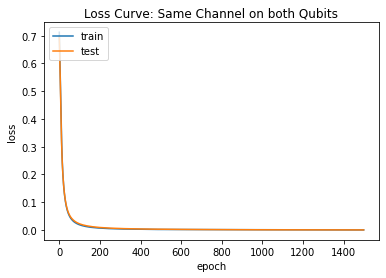

In [70]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
score = model.evaluate(x_test,  y_test, verbose=2)

25/25 - 0s - loss: 5.8580e-05 - 498ms/epoch - 20ms/step


In [72]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((0.9999416+5.434231e-13j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [73]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [74]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [75]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [76]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[1800:1900]
y_val_list = vectors_noise_free[1800:1900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1900:]
y_test_list = vectors_noise_free[1900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [77]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [78]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [79]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1500)

Epoch 1/1500
8/8 [==============================] - 2s 65ms/step - loss: 0.7297 - val_loss: 0.7310
Epoch 2/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.6942 - val_loss: 0.6962
Epoch 3/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.6594 - val_loss: 0.6603
Epoch 4/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.6244 - val_loss: 0.6234
Epoch 5/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.5890 - val_loss: 0.5862
Epoch 6/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.5535 - val_loss: 0.5481
Epoch 7/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.5181 - val_loss: 0.5102
Epoch 8/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.4832 - val_loss: 0.4728
Epoch 9/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.4496 - val_loss: 0.4382
Epoch 10/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.4183 - val_loss: 0.4052
Epoch 11/

8/8 [==============================] - 0s 13ms/step - loss: 0.0246 - val_loss: 0.0323
Epoch 84/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0242 - val_loss: 0.0318
Epoch 85/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0238 - val_loss: 0.0314
Epoch 86/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0234 - val_loss: 0.0309
Epoch 87/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0230 - val_loss: 0.0304
Epoch 88/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0226 - val_loss: 0.0299
Epoch 89/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0222 - val_loss: 0.0295
Epoch 90/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0219 - val_loss: 0.0291
Epoch 91/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0215 - val_loss: 0.0286
Epoch 92/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0212 - val_loss: 0.0282
Epoch 93/1500


8/8 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0140
Epoch 165/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0139
Epoch 166/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 167/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0137
Epoch 168/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0136
Epoch 169/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.0135
Epoch 170/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0135
Epoch 171/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0133
Epoch 172/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0133
Epoch 173/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0132
Epoch

8/8 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0088
Epoch 246/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 247/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 248/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 249/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0086
Epoch 250/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0086
Epoch 251/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0085
Epoch 252/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0085
Epoch 253/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0085
Epoch 254/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0084
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 327/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 328/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 329/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 330/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 331/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 332/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 333/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 334/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 335/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 408/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 409/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 410/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 411/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 412/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 413/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 414/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 415/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 416/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 489/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 490/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 491/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 492/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 493/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 494/1500
8/8 [==============================] - 0s 21ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 495/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 496/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 497/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 570/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 571/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 572/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 573/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 574/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 575/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 576/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 577/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 578/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch

8/8 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 651/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 652/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 653/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 654/1500
8/8 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 655/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 656/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 657/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 658/1500
8/8 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 659/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch

8/8 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 732/1500
8/8 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 733/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 734/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 735/1500
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 736/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 737/1500
8/8 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 738/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 739/1500
8/8 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 740/1500
8/8 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch

Epoch 812/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.7537e-04 - val_loss: 0.0020
Epoch 813/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.7317e-04 - val_loss: 0.0020
Epoch 814/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.6818e-04 - val_loss: 0.0020
Epoch 815/1500
8/8 [==============================] - 0s 14ms/step - loss: 9.6736e-04 - val_loss: 0.0020
Epoch 816/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.6773e-04 - val_loss: 0.0020
Epoch 817/1500
8/8 [==============================] - 0s 15ms/step - loss: 9.6499e-04 - val_loss: 0.0020
Epoch 818/1500
8/8 [==============================] - 0s 16ms/step - loss: 9.6239e-04 - val_loss: 0.0020
Epoch 819/1500
8/8 [==============================] - 0s 17ms/step - loss: 9.5309e-04 - val_loss: 0.0020
Epoch 820/1500
8/8 [==============================] - 0s 14ms/step - loss: 9.5027e-04 - val_loss: 0.0020
Epoch 821/1500
8/8 [==============================] - 0

8/8 [==============================] - 0s 13ms/step - loss: 7.9815e-04 - val_loss: 0.0017
Epoch 891/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.9632e-04 - val_loss: 0.0017
Epoch 892/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.9254e-04 - val_loss: 0.0017
Epoch 893/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.9030e-04 - val_loss: 0.0017
Epoch 894/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.8579e-04 - val_loss: 0.0017
Epoch 895/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.8765e-04 - val_loss: 0.0017
Epoch 896/1500
8/8 [==============================] - 0s 15ms/step - loss: 7.8848e-04 - val_loss: 0.0017
Epoch 897/1500
8/8 [==============================] - 0s 16ms/step - loss: 7.8678e-04 - val_loss: 0.0017
Epoch 898/1500
8/8 [==============================] - 0s 14ms/step - loss: 7.7942e-04 - val_loss: 0.0017
Epoch 899/1500
8/8 [==============================] - 0s 15ms/step - l

8/8 [==============================] - 0s 17ms/step - loss: 6.5842e-04 - val_loss: 0.0015
Epoch 969/1500
8/8 [==============================] - 0s 18ms/step - loss: 6.6130e-04 - val_loss: 0.0015
Epoch 970/1500
8/8 [==============================] - 0s 21ms/step - loss: 6.5412e-04 - val_loss: 0.0014
Epoch 971/1500
8/8 [==============================] - 0s 16ms/step - loss: 6.5380e-04 - val_loss: 0.0014
Epoch 972/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.5567e-04 - val_loss: 0.0014
Epoch 973/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.5275e-04 - val_loss: 0.0014
Epoch 974/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.5609e-04 - val_loss: 0.0014
Epoch 975/1500
8/8 [==============================] - 0s 18ms/step - loss: 6.5294e-04 - val_loss: 0.0014
Epoch 976/1500
8/8 [==============================] - 0s 17ms/step - loss: 6.4624e-04 - val_loss: 0.0014
Epoch 977/1500
8/8 [==============================] - 0s 20ms/step - l

8/8 [==============================] - 0s 14ms/step - loss: 5.5135e-04 - val_loss: 0.0013
Epoch 1046/1500
8/8 [==============================] - 0s 14ms/step - loss: 5.5320e-04 - val_loss: 0.0013
Epoch 1047/1500
8/8 [==============================] - 0s 15ms/step - loss: 5.5591e-04 - val_loss: 0.0013
Epoch 1048/1500
8/8 [==============================] - 0s 15ms/step - loss: 5.5437e-04 - val_loss: 0.0012
Epoch 1049/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.5170e-04 - val_loss: 0.0012
Epoch 1050/1500
8/8 [==============================] - 0s 18ms/step - loss: 5.4485e-04 - val_loss: 0.0012
Epoch 1051/1500
8/8 [==============================] - 0s 15ms/step - loss: 5.4551e-04 - val_loss: 0.0012
Epoch 1052/1500
8/8 [==============================] - 0s 16ms/step - loss: 5.4635e-04 - val_loss: 0.0012
Epoch 1053/1500
8/8 [==============================] - 0s 17ms/step - loss: 5.4450e-04 - val_loss: 0.0012
Epoch 1054/1500
8/8 [==============================] - 0s 17ms

8/8 [==============================] - 0s 17ms/step - loss: 4.6291e-04 - val_loss: 0.0011
Epoch 1123/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5904e-04 - val_loss: 0.0011
Epoch 1124/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5799e-04 - val_loss: 0.0011
Epoch 1125/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5908e-04 - val_loss: 0.0011
Epoch 1126/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.5643e-04 - val_loss: 0.0011
Epoch 1127/1500
8/8 [==============================] - 0s 16ms/step - loss: 4.5417e-04 - val_loss: 0.0010
Epoch 1128/1500
8/8 [==============================] - 0s 20ms/step - loss: 4.5191e-04 - val_loss: 0.0010
Epoch 1129/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5185e-04 - val_loss: 0.0010
Epoch 1130/1500
8/8 [==============================] - 0s 17ms/step - loss: 4.5233e-04 - val_loss: 0.0011
Epoch 1131/1500
8/8 [==============================] - 0s 18ms

Epoch 1198/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.8825e-04 - val_loss: 9.1357e-04
Epoch 1199/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.8592e-04 - val_loss: 9.0078e-04
Epoch 1200/1500
8/8 [==============================] - 0s 16ms/step - loss: 3.8306e-04 - val_loss: 8.9790e-04
Epoch 1201/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.8242e-04 - val_loss: 9.0069e-04
Epoch 1202/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.8156e-04 - val_loss: 8.9942e-04
Epoch 1203/1500
8/8 [==============================] - 0s 13ms/step - loss: 3.8372e-04 - val_loss: 9.0101e-04
Epoch 1204/1500
8/8 [==============================] - 0s 13ms/step - loss: 3.8190e-04 - val_loss: 9.0494e-04
Epoch 1205/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.8130e-04 - val_loss: 8.8880e-04
Epoch 1206/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.7911e-04 - val_loss: 8.9297e-04
Epoch 1207

8/8 [==============================] - 0s 14ms/step - loss: 3.2175e-04 - val_loss: 7.7087e-04
Epoch 1273/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.2256e-04 - val_loss: 7.6831e-04
Epoch 1274/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.2069e-04 - val_loss: 7.7213e-04
Epoch 1275/1500
8/8 [==============================] - 0s 13ms/step - loss: 3.2420e-04 - val_loss: 7.8548e-04
Epoch 1276/1500
8/8 [==============================] - 0s 13ms/step - loss: 3.2843e-04 - val_loss: 7.8844e-04
Epoch 1277/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.2182e-04 - val_loss: 7.7035e-04
Epoch 1278/1500
8/8 [==============================] - 0s 15ms/step - loss: 3.1896e-04 - val_loss: 7.6835e-04
Epoch 1279/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.1718e-04 - val_loss: 7.6825e-04
Epoch 1280/1500
8/8 [==============================] - 0s 14ms/step - loss: 3.1709e-04 - val_loss: 7.6342e-04
Epoch 1281/1500
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 2.6588e-04 - val_loss: 6.4697e-04
Epoch 1347/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.6342e-04 - val_loss: 6.4497e-04
Epoch 1348/1500
8/8 [==============================] - 0s 14ms/step - loss: 2.6125e-04 - val_loss: 6.5657e-04
Epoch 1349/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6139e-04 - val_loss: 6.4881e-04
Epoch 1350/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.6193e-04 - val_loss: 6.4752e-04
Epoch 1351/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6282e-04 - val_loss: 6.4467e-04
Epoch 1352/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6256e-04 - val_loss: 6.4215e-04
Epoch 1353/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.6090e-04 - val_loss: 6.4061e-04
Epoch 1354/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.6306e-04 - val_loss: 6.3772e-04
Epoch 1355/1500
8/8 [=====

8/8 [==============================] - 0s 14ms/step - loss: 2.1650e-04 - val_loss: 5.4125e-04
Epoch 1421/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.1473e-04 - val_loss: 5.4651e-04
Epoch 1422/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.1359e-04 - val_loss: 5.4178e-04
Epoch 1423/1500
8/8 [==============================] - 0s 14ms/step - loss: 2.1368e-04 - val_loss: 5.4091e-04
Epoch 1424/1500
8/8 [==============================] - 0s 16ms/step - loss: 2.1351e-04 - val_loss: 5.3809e-04
Epoch 1425/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.1431e-04 - val_loss: 5.3717e-04
Epoch 1426/1500
8/8 [==============================] - 0s 15ms/step - loss: 2.1347e-04 - val_loss: 5.4473e-04
Epoch 1427/1500
8/8 [==============================] - 0s 14ms/step - loss: 2.1341e-04 - val_loss: 5.3870e-04
Epoch 1428/1500
8/8 [==============================] - 0s 13ms/step - loss: 2.1120e-04 - val_loss: 5.3559e-04
Epoch 1429/1500
8/8 [=====

8/8 [==============================] - 0s 15ms/step - loss: 1.7044e-04 - val_loss: 4.4801e-04
Epoch 1495/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.7002e-04 - val_loss: 4.5093e-04
Epoch 1496/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.6960e-04 - val_loss: 4.5343e-04
Epoch 1497/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.6998e-04 - val_loss: 4.4510e-04
Epoch 1498/1500
8/8 [==============================] - 0s 15ms/step - loss: 1.6793e-04 - val_loss: 4.4260e-04
Epoch 1499/1500
8/8 [==============================] - 0s 13ms/step - loss: 1.6858e-04 - val_loss: 4.4364e-04
Epoch 1500/1500
8/8 [==============================] - 0s 14ms/step - loss: 1.6835e-04 - val_loss: 4.4485e-04


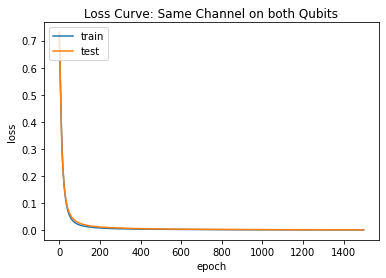

In [80]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 4.0566e-04 - 356ms/epoch - 89ms/step


In [82]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((0.99959433+5.2386897e-12j), shape=(), dtype=complex64)
